In [1]:
# подготовка к домашке урока 6:))
import pandahouse as ph # библиотека для работы с SQL в питоне
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
connection_default = {'host':'https://clickhouse.lab.karpov.courses', # подключаемся к аккаунту обычному
                     'database':'default',
                     'user':'student',
                     'password':'dpo_python_2020'}

connection_test = dict(host = 'https://clickhouse.lab.karpov.courses', # подключаемся к аккаунту с правами на редактирование с создание таблиц
                       database = 'test',
                       user = 'student-rw',
                       password = '656e2b0c9c')

In [7]:
# смотрим количество строк в таблице -- 6.2
q_check_read = '''
    SELECT count()
    FROM {db}.ldn_listings
    '''
q_check = ph.read_clickhouse(query = q_check_read, connection = connection_default)
q_check

,count()
0,85207


In [19]:
# выгружаем из таблицы данные о цене в зависимости от типа жилья -- 6.3
q_price_of_room_type_read = '''
    SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, -- грёбанные кавычки в паттерне!:(
        room_type
    FROM {db}.ldn_listings
    ORDER BY id ASC
    LIMIT 1000
    '''
q_price_of_room_type = ph.read_clickhouse(query = q_price_of_room_type_read, connection = connection_default)
# считаем 75-й перцентиль для каждого типа комнат и выводим 
q_75 = q_price_of_room_type \
    .groupby(by=['room_type'], as_index=False) \
    .quantile(q = 0.75)
q_75

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


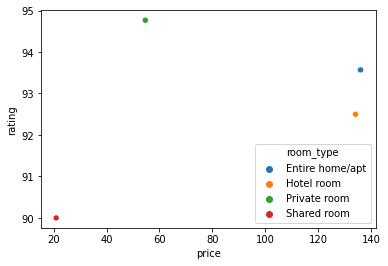

In [29]:
# строим график рассеивания, показывающий зависимость средней оценки от средней цены по типу жилья -- 6.4
q_plus_rating_read = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS rating
    FROM {db}.ldn_listings
    WHERE review_scores_rating != ''
    LIMIT 1000
    '''
q_plus_rating = ph.read_clickhouse(query = q_plus_rating_read, connection = connection_default)
# группируем по типу жилья и считаем среднее для цены и рейтинга
q_means = q_plus_rating.groupby(by=['room_type'], as_index=False)[['price','rating']].agg('mean')
sns.scatterplot(data=q_means, x="price", y="rating", hue="room_type")

In [72]:
# Проверяем, какие способы подтверждения аккаунта использовали хозяева, предлагающие "впечатления" -- 6.5
q_experience_read = '''
    SELECT 
        DISTINCT host_id,
        host_verifications
    FROM {db}.ldn_listings
    WHERE experiences_offered != 'none'
    '''
q_experience = ph.read_clickhouse(query = q_experience_read, connection = connection_default)
# Считаем, сколько раз встречался каждый способ верификации

# Обрабатываем столбец -- заменяем строковое представление списка на список строк 
q_experience['host_verifications'] = q_experience['host_verifications'] \
    .apply(lambda x: x.strip('"[] ')) \
    .apply(lambda c: c.replace("'", "")) \
    .apply(lambda y: y.split(', '))

# если применять explode к столбцу - подучается какая-то дичь:(
q_experience_values = q_experience \
    .explode('host_verifications') \
    ['host_verifications'].value_counts()
q_experience_values

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64